In [4]:
dataset = 'creditcard_short.csv.tar.gz'

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm



eps = sys.float_info.epsilon
%matplotlib inline
plt.style.use('ggplot')
print(tf.__version__)

2.4.0


In [6]:
data = pd.read_csv(dataset, compression='gzip', dtype=np.float32).iloc[:, 1:]
data.dropna(inplace=True)
data['Class'].replace(0, -1, inplace=True)
X, y = data.iloc[:, :-1].values, data['Class'].values.reshape(-1, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=46)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=46)

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [9]:
class myModel(Model):
    def __init__(self):
        super(myModel, self).__init__()
        self.w = tf.Variable(np.random.randn(X.shape[1], 1), trainable=True, dtype=np.float32, name='w')
        self.b = tf.Variable(1, trainable=True, dtype=np.float32, name='bias')

    def call(self, X):
        y = tf.subtract(tf.matmul(X, self.w), self.b)
        return y


class trainModel:
    def __init__(self, model, Learning_rate, Lambda, n_epochs, batch_size):
        self.model = model
        self.lr = Learning_rate
        self.l = Lambda
        self.epochs = n_epochs
        self.batch_size = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr, decay=0.01)
        self.epoch_losses = []
        self.epoch_accuracies = []
        self.epoch_val_losses = []
        self.epoch_val_accuracies = []
        self.mini_batch_losses = []
        self.mini_batch_accuracies = []
        self.history = {}
    
    def mini_batch_generator(self, X, y):
        num_minibatches = int(len(X) / self.batch_size)
        for i in range(num_minibatches):
            data_batch = X[i * self.batch_size:(i + 1) * self.batch_size]
            label_batch = y[i * self.batch_size:(i + 1) * self.batch_size]
            yield data_batch, label_batch
        if len(X) % self.batch_size != 0:
            data_batch = X[num_minibatches * self.batch_size:]
            label_batch = y[num_minibatches * self.batch_size:]
            yield data_batch, label_batch

    def loss(self, y, y_hat):

        l2_norm = tf.reduce_sum(tf.square(self.model.w))
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1.,tf.multiply(y_hat, y))))
        return tf.add(classification_term, tf.multiply(self.l, l2_norm))
        
    def predict(self, X):
        return tf.math.sign(self.model([X]))

    def eval(self, X, y):
        preds = self.predict(X).numpy()[0, :]
        accuracy = tf.reduce_mean(tf.dtypes.cast(tf.equal(preds, y), tf.float32))
        loss = self.loss(y, preds)
        return loss.numpy(), accuracy.numpy()

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        for epoch in range(self.epochs):
            # Shuffle Data
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]

            for X_train_batch, y_train_batch in self.mini_batch_generator(X_train, y_train):

                with tf.GradientTape(persistent=False) as tape:

                    preds = self.model(X_train_batch)
                    loss = self.loss(y_train_batch, preds)
               
                gradients = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                loss, acc = self.eval(X_train, y_train)

                self.mini_batch_losses.append(loss)
                self.mini_batch_accuracies.append(acc)

            self.epoch_losses.append(np.mean(self.mini_batch_losses))
            self.epoch_accuracies.append(np.mean(self.mini_batch_accuracies))
            
            if X_val is not None:
                val_loss, val_metric = self.eval(X_val, y_val)
                self.epoch_val_losses.append(val_loss)
                self.epoch_val_accuracies.append(val_metric)
                print(f'\rEpoch {epoch+1}/{self.epochs} train_loss:{self.epoch_losses[epoch]:3.3f}, train_acc:{self.epoch_accuracies[epoch]:3.3f}, val_loss:{val_loss:f}, val_acc:{val_metric:3.3f}', end="")
            else:
                print(f'\rEpoch {epoch+1}/{self.epochs} train loss:{self.epoch_losses[epoch]:3.3f}, train_acc:{self.epoch_accuracies[epoch]:3.3f}', end="")
            
        print()
        self.history['train_accuracy'] = self.epoch_accuracies
        self.history['train_loss'] = self.epoch_losses

        if X_val is not None:
            self.history['val_accuracy'] = self.epoch_val_accuracies
            self.history['val_loss'] = self.epoch_val_losses

        return





In [10]:
model = myModel()

trained_model = trainModel(model, Learning_rate=0.01, Lambda=0, n_epochs=50, batch_size=1024)
trained_model.fit(X_train, y_train, X_val, y_val)


Epoch 50/50 train_loss:0.021, train_acc:0.989, val_loss:0.001510, val_acc:0.999


In [11]:
print(f'Test Accuracy: {trained_model.eval(X_test, y_test)[1]:3.3f}')

Test Accuracy: 0.999


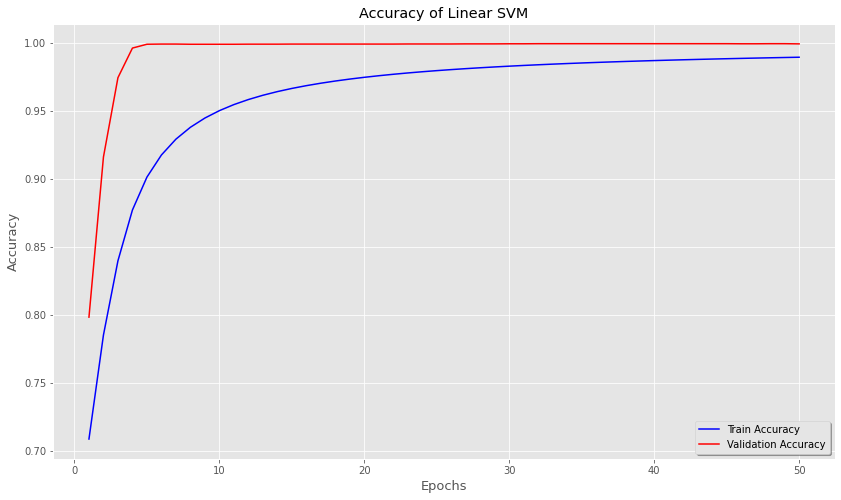

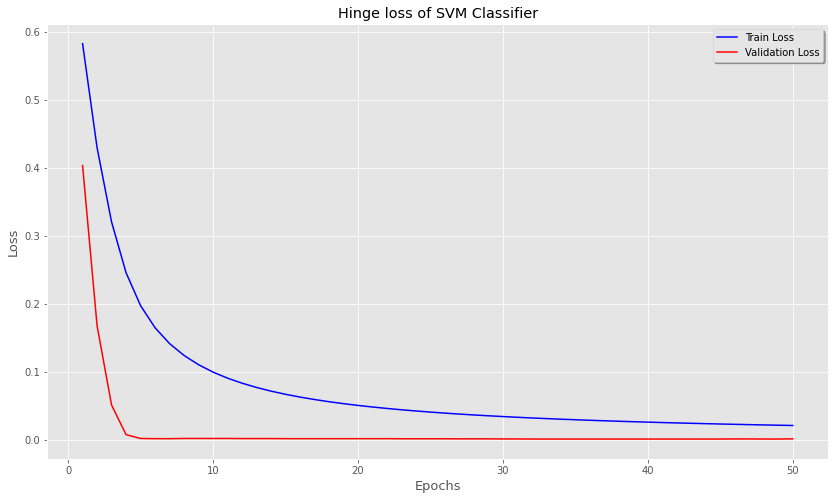

In [12]:
train_accuracy = trained_model.history['train_accuracy']
train_loss = trained_model.history['train_loss']
validation_accuracy = trained_model.history['val_accuracy']
validation_loss = trained_model.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 8))
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy of Linear SVM')
plt.legend(shadow=True)
plt.savefig('acc', dpi=150, bbox_inches='tight')

plt.figure(figsize=(14, 8))
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.title('Hinge loss of SVM Classifier')
plt.legend(shadow=True)
plt.savefig('loss', dpi=150, bbox_inches='tight')


plt.show()